In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipd
from glob import glob
import librosa
import seaborn as sns
import librosa.display
import skimage.io

In [37]:
DATA_PATH = "./data/"
PROCESSED_TRAIN_DATA_PATH = "./data/processed_train/"
PROCESSED_TEST_DATA_PATH = "./data/processed_test/"

class conf:
    # settings
    # number of samples per time-step in spectrogram. Defaults to win_length / 4
    # Also the step or stride between windows. If the step is smaller than the window length, the windows will overlap
    hop_length = 512 
    # number of bins in spectrogram. Height of image
    n_mels = 128 
    # number of time-steps. Width of image
    time_steps = 512 
    # number of samples per second
    sampling_rate = 22050
    # sec
    duration = 10 
    fmin = 20
    fmax = sampling_rate // 2
    # FFT window size or length of the windowed signal after padding with zeros. Default value = 2048 ( for music signals)    
    n_fft = hop_length * 4
    # Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft. Defaults to n_fft
    win_length = hop_length * 4    
    padmode = 'constant'
    samples = sampling_rate * duration

In [38]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_train["file_exists"] = df_train.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_train.head()

,song_id,filename,filepath,genre_id,genre,file_exists
0,10150,010150.ogg,train/010150.ogg,7,Instrumental,True
1,7358,007358.ogg,train/007358.ogg,2,Punk,True
2,20573,020573.ogg,train/020573.ogg,5,Folk,True
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic,True
4,16662,016662.ogg,train/016662.ogg,1,Rock,True


In [39]:
df_train[~df_train.file_exists]

,song_id,filename,filepath,genre_id,genre,file_exists
1359,3137,003137.ogg,train/003137.ogg,1,Rock,False
4668,11088,011088.ogg,train/011088.ogg,2,Punk,False
5150,16312,016312.ogg,train/016312.ogg,7,Instrumental,False
8764,24899,024899.ogg,train/024899.ogg,0,Electronic,False
10155,4040,004040.ogg,train/004040.ogg,4,Hip-Hop,False
10873,9963,009963.ogg,train/009963.ogg,3,Experimental,False
11386,15980,015980.ogg,train/015980.ogg,4,Hip-Hop,False
11497,22698,022698.ogg,train/022698.ogg,4,Hip-Hop,False
14377,23078,023078.ogg,train/023078.ogg,5,Folk,False
14827,17940,017940.ogg,train/017940.ogg,0,Electronic,False


In [40]:
df_test = pd.read_csv(DATA_PATH + "test.csv")
df_test["file_exists"] = df_test.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_test.head()

,song_id,filename,filepath,file_exists
0,7072,007072.ogg,test/007072.ogg,True
1,10207,010207.ogg,test/010207.ogg,True
2,20008,020008.ogg,test/020008.ogg,True
3,10924,010924.ogg,test/010924.ogg,True
4,21896,021896.ogg,test/021896.ogg,True


In [41]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=None, res_type="kaiser_fast")
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = conf.time_steps * conf.hop_length    
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[start_sample : start_sample+length_samples]        
    else: # pad blank
        padding = length_samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y, sr

In [42]:
def create_mel_sepc(audio_path):
    y, sr = read_audio(conf, audio_path, True)    
    mels = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=conf.n_mels,
        n_fft=conf.n_fft, 
        hop_length=conf.hop_length
    )
    # convert amplitude to decibels
    mels = librosa.power_to_db(mels, ref=np.max)    
    return mels 

In [43]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def save_melspec_image(mels, img_path):
    if not os.path.exists(img_path):                                        
        # min-max scale to fit inside 8-bit range
        img = scale_minmax(mels, 0, 255).astype(np.uint8)
        img = np.flip(img, axis=0) # put low frequencies at the bottom in image
        img = 255-img # invert. make black==more energy
        img = np.stack([img]*3, axis=-1)
        # save as PNG
        skimage.io.imsave(img_path, img)
        return img

In [44]:
def show_spectrogram(spec, title, sr, hop_length, y_axis='log', x_axis='time'):
    librosa.display.specshow(spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

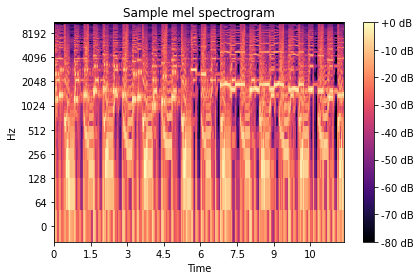

In [45]:
# test by generating and displaying some mel spectrograms
audio_path = "./data/train/000002.ogg"
sample_mels = create_mel_sepc(audio_path)
show_spectrogram(sample_mels, "Sample mel spectrogram", sr=conf.sampling_rate, hop_length=conf.hop_length)

In [46]:
sample_mels_img = save_melspec_image(sample_mels, "000002_1.jpg")

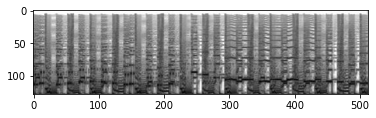

In [47]:
from PIL import Image
img = Image.open("000002_1.jpg")
plt.imshow(img)

In [48]:
img_arr = np.array(img)
img_arr.shape

(128, 513, 3)

In [49]:
import os

def create_processing_dirs():
    if not os.path.isdir(PROCESSED_TRAIN_DATA_PATH):
        os.mkdir(PROCESSED_TRAIN_DATA_PATH)
    if not os.path.isdir(PROCESSED_TEST_DATA_PATH):
        os.mkdir(PROCESSED_TEST_DATA_PATH)            

In [50]:
def audio_to_melspec(file_path, folder_path):
    filename_no_ext = file_path.split("/")[-1].split(".")[0]
    file_path = DATA_PATH + file_path    
    if os.path.exists(file_path):
        mels = create_mel_sepc(file_path)
        if not os.path.isdir(folder_path + "mel_spec/"):
            os.mkdir(folder_path + "mel_spec/")
        mels_img_path = folder_path + "mel_spec/" + filename_no_ext + ".jpg"        
        mels_img = save_melspec_image(mels, mels_img_path)                 
    return file_path

In [51]:
from tqdm.notebook import tqdm
from joblib import delayed, Parallel

create_processing_dirs()
df_train = df_train.head(10)
delayed_funcs_train = [delayed(audio_to_melspec)(row["filepath"], PROCESSED_TRAIN_DATA_PATH) 
                       for i, row in df_train[df_train.file_exists].iterrows()]
results_train = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_train)    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


In [52]:
# delayed_funcs_test = [delayed(audio_to_melspec)(row["filepath"], "/kaggle/test/") 
#                       for i, row in df_test[df_test.file_exists].iterrows()]
# results_test = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_test)    

In [53]:
# zip the processed_train and processed_test folders
!zip -rq spectograms.zip /kaggle/processed_train/mel_spec
!zip -rq spectograms.zip /kaggle/processed_test/mel_spec

^C
